# Проверка распределений на совпадение и независимость частей при помощи различных критериев

In [1]:
# Подключение пакетов
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns

## 1. Собственная функция нормального распределения и ее сравнение с numpy
Ниже приведен код самой функции, и генерация распределения для примера.

In [2]:
# Normal distribution function
def normal_dist(x , mean , sd):
    prob_density = 1/(np.sqrt(2*np.pi)*sd) * np.exp(-0.5*((x-mean)/sd)**2)
    return prob_density

x = np.linspace(-5,5,200)
pdf = normal_dist(x,0,1)
a = np.random.normal(0,1,200)


### Сравнение
На графике ниже приведено сравнение гистограмм распределений, сгенерированных самостоятельно (custom distribution) и при помощи средств среды разработки (numpy distribution). Можно заметить, что они практически совпадают. Различия возникают из-за малого числа элементов для сравнения.

Text(0, 0.5, 'Density')

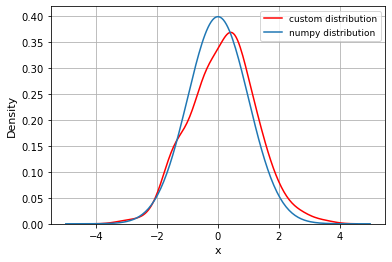

In [3]:
sns.kdeplot(a, fill=False, color='red', label='custom distribution')
plt.plot(x, pdf, label='numpy distribution')
plt.legend(loc='upper right', prop={'size': 9})
plt.grid()

plt.xlabel('x', fontsize=11)
plt.ylabel('Density', fontsize=11)

## Генерация распределений
Ниже приведен функционал генерирования распределений 3-х видов N(0, 1) - нормальное, K(0, 1) -Коши, R(0,1) - равномерное.
Все выборки генерируются програмными средствами.

In [4]:
# Function for all types of distributions
def generate_random_matrix(size, random_type):
    """
    Creates square matrix of random numbers
    :param size: Length of one side of a matrix
    :param random_type: Type of distribution in matrix (Gaussian - normal, Cauchy, Uniform) 
    the possible values are: 'gauss', 'cauchy', 'uniform'
    :return: Matrix as a np.array
    """
    # Gaussian distribution
    if random_type == 'gauss':
        mu, sigma = 0, 1 # mean and standard deviation(1, because dispersion is 1, sqrt(1) = 1)
        matrix = np.random.normal(mu, sigma, (size, size))
    # Cauchyan distribution
    if random_type == 'cauchy':
        matrix = np.random.standard_cauchy(size = (size,size))
    # Uniform distribution
    if random_type == 'uniform':
        matrix = np.random.uniform(0,1, size = (size,size))
    return matrix

Генерация выборок с заданными параметрами, размером 1024*1024, т.е.1048576.
$  
$  
$normal$ - Нормальное (Гаусса).
$cauchy$ - распределение Коши.
$uniform$ - равномерное.

In [5]:
normal = generate_random_matrix(1024, 'gauss')
cauchy = generate_random_matrix(1024, 'cauchy')
uniform = generate_random_matrix(1024, 'uniform')

Нормальное распределение:

In [7]:
print(np.sort(np.reshape(normal, -1)))

[-4.79998062 -4.60934044 -4.44741766 ...  4.64456213  4.84000005
  4.84255777]


Распределение Коши:

In [8]:
print(np.sort(np.reshape(cauchy, -1)))

[-709009.5878134  -467365.59906581 -174211.25982062 ...  698900.98504587
  794351.4208971  1944032.80566915]


Равномерное распределение:

In [9]:
print(np.sort(np.reshape(uniform, -1)))

[5.47999508e-07 9.49811783e-07 2.91367293e-06 ... 9.99999052e-01
 9.99999102e-01 9.99999689e-01]


## Проверки распределений
Далее будут представлены проверки соответствия выборок различным распределениям.

### Функция подсчета вероятности попадания элемента выборки на отрезок для каждого из исследуемых распределений

In [14]:
def probability(borders, random_type):
    """
    Counts probabilities for distributions on compacts
    :param borders: borders of the compact
    :param random_type: Type of distribution in matrix (Gaussian - normal, Cauchy, Uniform) 
    the possible values are: 'gauss', 'cauchy', 'uniform'
    :return: probability as a number
    """
    # Gaussian distribution
    if random_type == 'gauss':
        function_1 = 0.5 * (1+math.erf((borders[0]-0)/(np.sqrt(2))))
        function_2 = 0.5 * (1+math.erf((borders[1]-0)/(np.sqrt(2))))
        return function_2 - function_1
    # Cauchyan distribution
    if random_type == 'cauchy':
        function_1 = 1/np.pi*math.atan(borders[0])+0.5
        function_2 = 1/np.pi*math.atan(borders[1])+0.5
        return function_2 - function_1
    # Uniform distribution
    if random_type == 'uniform':
        if borders[1]>0 and borders[1]<1 and borders[0]>0 and borders[0]<1:
            return borders[1]-borders[0]
        else:
            return 0
    

Ниже производится расчет числа компактов, на которые делить числовой ряд, для текущей задачи. Их получается 174.

In [15]:
# Compact amount
compacts_amount = int(1.72*(1024*1024)**(1/3))
print(compacts_amount)

174


### Функция разбиения числового ряда на компакты

In [16]:
# Deviding definition area to compacts
def get_compacts(compacts_amount, size):
    compacts=[-size//2]
    current = -size//2
    step = size/compacts_amount
    for i in range(compacts_amount-1):
        current+=step
        compacts.append(current)
        compacts.append(current)
    compacts.append(size//2)
    return compacts

### Функция подсчета числа элементов на полуотрезке

In [17]:
# Counts amount of elemnts in compact
def elements_in_compact(data, compact):
    data = [x for x in data if x>=compact[0] and x<compact[1]]
    return len(data)

## Статистика Хи-квадрат
Ниже будет приведена проверка каждого из распределений по статистике Хи-Квадрат. Сначала данная статистика будет расчитана для каждой из гипотез для каждого из распределений, затем сравнена с квантилью распределения Хи-квадрат.

### Функция расчета статистики Хи-квадрат

In [18]:
# Calculates Hi^2 statistics
def hi_2_stats(array, compacts, random_type):
    stat = 0
    for index in range(len(compacts)//2):
        border_1 = compacts[2*index]
        border_2 = compacts[2*index+1]
        borders = [border_1, border_2]
        dots_in_compact = (elements_in_compact(array, borders))
        prob= probability(borders, random_type)
        if prob == 0:
            stat+=0
        else:
            stat+=((dots_in_compact-len(array)*prob)/np.sqrt(len(array)*prob))**2
    return stat

Осуществляется расчет статистики.

In [19]:
isnn = hi_2_stats(np.reshape(normal,-1), get_compacts(174,10), 'gauss')
isnu = hi_2_stats(np.reshape(normal,-1), get_compacts(174,10), 'uniform')
isnc = hi_2_stats(np.reshape(normal,-1), get_compacts(174,10), 'cauchy')
isun = hi_2_stats(np.reshape(uniform,-1), get_compacts(174,10), 'gauss')
isuu = hi_2_stats(np.reshape(uniform,-1), get_compacts(174,10), 'uniform')
isuc = hi_2_stats(np.reshape(uniform,-1), get_compacts(174,10), 'cauchy')
iscn = hi_2_stats(np.reshape(cauchy,-1), get_compacts(174,10), 'gauss')
iscu = hi_2_stats(np.reshape(cauchy,-1), get_compacts(174,10), 'uniform')
iscc = hi_2_stats(np.reshape(cauchy,-1), get_compacts(174,10), 'cauchy')

### Функция нахождения квантили распределения Хи-квадрат по аппроксимации Корниша-Фишера

In [20]:
# Caclculates Hi^2 quantile by Approximation of Cornish and Fisher
def cornish_fisher(quant, n):
    if quant>=0.5 and quant < 1:
        d = 2.0637*(np.log(1/(1-quant)-0.16))**0.4274 - 1.5774
    else:
        d = -2.0637*(np.log(1/quant-0.16))**0.4274 + 1.5774
    A = d*np.sqrt(2)
    B = 2/3 * (d**2-1)
    C = d*(d**2-7)/9/np.sqrt(2)
    D = (6*d**4+14*d**2-32)/405
    E = d*(9*d**4+256*d**2-433)/4860/np.sqrt(2)
    return n+A*np.sqrt(n)+B+C/np.sqrt(n)+D/n+E/n/np.sqrt(n)

Далее осуществляется проверка всех гипотез - сравнение статистик для каждой с квантилью распределения Хи-квадрат(99% или 95%), 173 степени свободы (число отрезков - 1).
Предпоследнее слово в каждом вопросе - название распределения выборки, последнее - проверяемого гипоттезой распределения. Далее записан результат проверки сначала, затем вероятность, с которой осуществлялась проверка. Последнее число - значение статистики.

In [41]:
print('Is generated normal normal?:', isnn<cornish_fisher(0.99, 173), '99%', isnn<cornish_fisher(0.95, 173), '95%. Statistics value:', isnn)
print('Is generated normal uniform?:', isnu<cornish_fisher(0.99, 173), '99%', isnu<cornish_fisher(0.95, 173), '95%. Statistics value:', isnu)
print('Is generated normal cauchy?:', isnc<cornish_fisher(0.99, 173), '99%', isnc<cornish_fisher(0.95, 173), '95%. Statistics value:', isnc)
print('Is generated uniform normal?:', isun<cornish_fisher(0.99, 173), '99%', isun<cornish_fisher(0.95, 173), '95%. Statistics value:', isun)
print('Is generated uniform uniform?:', isuu<cornish_fisher(0.99, 173), '99%', isuu<cornish_fisher(0.95, 173), '95%. Statistics value:', isuu)
print('Is generated uniform cauchy?:', isuc<cornish_fisher(0.99, 173), '99%', isuc<cornish_fisher(0.95, 173), '95%. Statistics value:', isuc)
print('Is generated cauchy normal?:', iscn<cornish_fisher(0.99, 173), '99%', iscn<cornish_fisher(0.95, 173), '95%. Statistics value:', iscn)
print('Is generated cauchy uniform?:', iscu<cornish_fisher(0.99, 173), '99%', iscu<cornish_fisher(0.95, 173), '95%. Statistics value:', iscu)
print('Is generated cauchy cauchy?:', iscc<cornish_fisher(0.99, 173), '99%', iscc<cornish_fisher(0.95, 173), '95%. Statistics value:', iscc)

Is generated normal normal?: True 99% True 95%. Statistics value: 180.2485959682966
Is generated normal uniform?: False 99% False 95%. Statistics value: 444570.6286716837
Is generated normal cauchy?: False 99% False 95%. Statistics value: 213643.35205562288
Is generated uniform normal?: False 99% False 95%. Statistics value: 2032916.5544902806
Is generated uniform uniform?: True 99% True 95%. Statistics value: 26.40108665378682
Is generated uniform cauchy?: False 99% False 95%. Statistics value: 3121472.4403112386
Is generated cauchy normal?: False 99% False 95%. Statistics value: 53324603.37661262
Is generated cauchy uniform?: False 99% False 95%. Statistics value: 575916.5840027232
Is generated cauchy cauchy?: True 99% True 95%. Statistics value: 162.43657337840344


Ниже записаны квантили распределения Хи-квадрат с 173 степенями свободы, расчитанные по аппроксимации Корниша-Фишера (сначала 99%, далее 95%).

In [27]:
print(cornish_fisher(0.99, 173), cornish_fisher(0.95, 173))

220.4929298747306 206.20077665046713


## Статистика Колмогорова
Ниже будет приведена проверка каждого из распределений по статистике Колмогорова. Сначала данная статистика будет расчитана для каждой из гипотез для каждого из распределений, затем сравнена с квантилью распределения Колмогорова.

### Функция расчета квантили распределения Колмогорова.

In [25]:
# Caclculates Kolmogorov quantile
def Kolmogorov_quantile(quant):
    return np.sqrt(-0.5*np.log((1-quant)/2))

Ниже записаны квантили, расчитанные для распределения Колмогорова (сначала 99%, далее 95%).

In [26]:
print(Kolmogorov_quantile(0.99), Kolmogorov_quantile(0.95))

1.627623630718729 1.3581015157406193


### Функция расчета статистики Колмогорова

In [28]:
# Calculates Kolmogorov statistics
def Kolmogorov_stats(array, compacts, random_type):
    stat = 0
    for index in range(len(compacts)//2):
        border_1 = compacts[2*index]
        border_2 = compacts[2*index+1]
        borders = [border_1, border_2]
        dots_in_compact = (elements_in_compact(array, borders))
        prob= probability(borders, random_type)
        temp_stat = np.max([dots_in_compact/len(array)-prob, prob - (dots_in_compact-1)/len(array)])
        stat = np.max([stat, temp_stat])
    return stat

Осуществляется расчет статистики.

In [30]:
k_isnn = Kolmogorov_stats(np.reshape(normal,-1), get_compacts(174,10), 'gauss')
k_isnu = Kolmogorov_stats(np.reshape(normal,-1), get_compacts(174,10), 'uniform')
k_isnc = Kolmogorov_stats(np.reshape(normal,-1), get_compacts(174,10), 'cauchy')
k_isun = Kolmogorov_stats(np.reshape(uniform,-1), get_compacts(174,10), 'gauss')
k_isuu = Kolmogorov_stats(np.reshape(uniform,-1), get_compacts(174,10), 'uniform')
k_isuc = Kolmogorov_stats(np.reshape(uniform,-1), get_compacts(174,10), 'cauchy')
k_iscn = Kolmogorov_stats(np.reshape(cauchy,-1), get_compacts(174,10), 'gauss')
k_iscu = Kolmogorov_stats(np.reshape(cauchy,-1), get_compacts(174,10), 'uniform')
k_iscc = Kolmogorov_stats(np.reshape(cauchy,-1), get_compacts(174,10), 'cauchy')

Далее осуществляется проверка всех гипотез - сравнение статистик для каждой с квантилью распределения Колмогорова(99% или 95%). Предпоследнее слово в каждом вопросе - название распределения выборки, последнее - проверяемого гипоттезой распределения. Далее записан результат проверки сначала, затем вероятность, с которой осуществлялась проверка.  Последнее число - значение статистики.

In [40]:
print('Is generated normal normal?:', k_isnn<Kolmogorov_quantile(0.99), '99%', k_isnn<Kolmogorov_quantile(0.95), '95%. Statistics value:', k_isnn)
print('Is generated normal uniform?:', k_isnu<Kolmogorov_quantile(0.99), '99%', k_isnu<Kolmogorov_quantile(0.95), '95%. Statistics value:', k_isnu)
print('Is generated normal cauchy?:', k_isnc<Kolmogorov_quantile(0.99), '99%', k_isnc<Kolmogorov_quantile(0.95), '95%. Statistics value:', k_isnc)
print('Is generated uniform normal?:', k_isun<Kolmogorov_quantile(0.99), '99%', k_isun<Kolmogorov_quantile(0.95), '95%. Statistics value:', k_isun)
print('Is generated uniform uniform?:', k_isuu<Kolmogorov_quantile(0.99), '99%', k_isuu<Kolmogorov_quantile(0.95), '95%. Statistics value:', k_isuu)
print('Is generated uniform cauchy?:', k_isuc<Kolmogorov_quantile(0.99), '99%', k_isuc<Kolmogorov_quantile(0.95), '95%. Statistics value:', k_isuc)
print('Is generated cauchy normal?:', k_iscn<Kolmogorov_quantile(0.99), '99%', k_iscn<Kolmogorov_quantile(0.95), '95%. Statistics value:', k_iscn)
print('Is generated cauchy uniform?:', k_iscu<Kolmogorov_quantile(0.99), '99%', k_iscu<Kolmogorov_quantile(0.95), '95%. Statistics value:', k_iscu)
print('Is generated cauchy cauchy?:', k_iscc<Kolmogorov_quantile(0.99), '99%', k_iscc<Kolmogorov_quantile(0.95), '95%. Statistics value:', k_iscc)

Is generated normal normal?: True 99% True 95%. Statistics value: 0.00024866279013441295
Is generated normal uniform?: True 99% True 95%. Statistics value: 0.04293345308851926
Is generated normal cauchy?: True 99% True 95%. Statistics value: 0.005931930429914856
Is generated uniform normal?: True 99% True 95%. Statistics value: 0.0430667684120023
Is generated uniform uniform?: True 99% True 95%. Statistics value: 0.023180007934570312
Is generated uniform cauchy?: True 99% True 95%. Statistics value: 0.04805816025960474
Is generated cauchy normal?: True 99% True 95%. Statistics value: 0.005913709933301703
Is generated cauchy uniform?: True 99% True 95%. Statistics value: 0.04776762819838254
Is generated cauchy cauchy?: True 99% True 95%. Statistics value: 0.00030206516835817876


## Статистика Стьюдента
Далее будет проверяться независимость 1-й и 2-й половин случайного поля для всех распределений по статистике Стьюдента. Сначала будет проводиться расчет статистики, затем она будет сравниваться с квантилью распределения стьюдента 1099511627776 степеней свободы (квадрат (числа элементов - 1) каждой из выборок).

### Функция расчета статистики Стьюдента

In [34]:
def first_momentum(array):
    return 2/len(array)*np.sum(np.sort(array)[0:len(array)//2])
def second_momentum(array):
    return 2/len(array)*np.sum(np.sort(array)[len(array)//2:len(array)])
def correlation_coefficient(array):
    first_part = np.sort(array)[0:len(array)//2]-first_momentum(array)
    second_part = np.sort(array)[len(array)//2:len(array)]-second_momentum(array)
    denominator = np.sum(first_part*second_part)
    devidor_1 = np.sum((np.sort(array)[0:len(array)//2]-first_momentum(array))**2)
    devidor_2 = np.sum((np.sort(array)[len(array)//2:len(array)]-second_momentum(array))**2)
    devidor = np.sqrt(devidor_1*devidor_2)
    return denominator/devidor
def Student_stats(array):
    r = correlation_coefficient(array)
    return r/np.sqrt(1-r**2)*np.sqrt(len(array)-2)

99-я квантиль распределения Стьюдента 1099511627776 степеней свободы (квадрат (числа элементов - 1) каждой из выборок).
Значение: 2.28 .

In [35]:
student_quantile = 2.28

Расчет статистики.

In [36]:
i_n = Student_stats(np.reshape(normal,-1))
i_u = Student_stats(np.reshape(cauchy,-1))
i_c = Student_stats(np.reshape(uniform,-1))

Осуществляется проверка всех гипотез - сравнение статистик для каждой с квантилью распределения Стьюдента(99%). Вопрос о независимости половин распределения, 3-е слово - название распределения. Далее записан результат проверки сначала, затем вероятность, с которой осуществлялась проверка. Последнее число - значение статистики.

In [39]:
print('Are generated normal halfes independent?:', i_n<=student_quantile, '99%. Statistics value:', i_n)
print('Are generated uniform halfes independent?:', i_u<=student_quantile, '99%. Statistics value:', i_u)
print('Are generated cauchy halfes independent?:', i_c<=student_quantile, '99%. Statistics value:', i_c)

Are generated normal halfes independent?: False 99%. Statistics value: 1708.4476480801914
Are generated uniform halfes independent?: True 99%. Statistics value: 0.04201092903919887
Are generated cauchy halfes independent?: False 99%. Statistics value: 456410.4678466039
